# Manifold Muon

In this notebook, we're going to train a transformer with precise control over the size of the weights.

We'll see how manifold-constrained optimization will let us control numerical properties during training.

## Getting the data

First, let's download the Shakespeare dataset. The task will be to predict the next character.

In [1]:
context = 64
batch_size = 12

from data.shakespeare import load_shakespeare

data = load_shakespeare(context, batch_size)

train_loader = data["train_loader"]
val_loader = data["val_loader"]
encode = data["encode"]
decode = data["decode"]

Let's peek at an example to verify the data loaded correctly!

In [2]:
for inputs, targets in train_loader:
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    print("First input sequence:", inputs[0][:10], "...")
    print("First target sequence:", targets[0][:10], "...")
    print("\nDecoded input:", decode(inputs[0]))
    print("\nDecoded target:", decode(targets[0]))
    break

Input shape: (12, 64)
Target shape: (12, 64)
First input sequence: [41 53 50 42  1 40 50 53 53 42] ...
First target sequence: [53 50 42  1 40 50 53 53 42  1] ...

Decoded input: cold blood no spark of honour bides.

NORTHUMBERLAND:
Be thou a 

Decoded target: old blood no spark of honour bides.

NORTHUMBERLAND:
Be thou a p


## Defining the architecture

Let's use a very small setting for our transformer so it is fast to train.

In [3]:
# transformer hyperparameters

vocab_size = 65
num_heads = 4
d_embed = 128
num_blocks = 4
attention_scale = 1
final_scale = 1

# training hyperparameters

lr = 0.1
wd = 0
beta = 0.95
steps = 2001
log_interval = 10
val_interval = 100
val_iters = 20

 Next up, we'll define the *attention* module and *residual blocks*.

## Attention in Modula

In Modula, we'll define attention by stringing together several bond modules to do the parameterless computations. The roadmap is:
* Map `(batch, token, d_embed)` into `(batch, head, token, d_query)` (and same for key and value) via `Linear` and `SplitIntoHeads`
* Use Rotary Positional Embeddings (RoPE) on the query and the key via `Rope`
* Map `query` and `key` into attention similarities of shape `(batch, head, token, token)` via `AttentionQK`
* Use a causal mask and then softmax to create attention scores via `CausalMask` and `Softmax`
* Use the attention scores to create output vectors via `ApplyAttentionScores`, then `MergeHeads` and `Linear`

The main difference to a standard transformer is that `AttentionQK` uses $1/d_\text{head}$ scaling instead of the standard $1/\sqrt{d_\text{head}}$. The reason for this is to provide Lipschitz guarantees for attention that are independent of $d_\text{head}$. For more information on this, see Appendix B.6 of [Scalable Optimization in the Modular Norm](https://arxiv.org/pdf/2405.14813).

And here's the implementation:

In [4]:
from modula.atom import HeadedLinear, HeadedLinearOut
from modula.bond import TransposeHeads, ReduceHeads, Rope, AttentionQK, CausalMask, Softmax, ApplyAttentionScores, GeLU

def OrthogonalAttention(num_heads, d_embed, softmax_scale, layer_idx=0):
    """
    Orthogonal attention uses 3-tensors for Q, K, V to make the input and output dimensions explicitly equal.
    """
    Q = TransposeHeads() @ HeadedLinear(num_heads, d_embed, d_embed, tracker=f"q{layer_idx}")
    K = TransposeHeads() @ HeadedLinear(num_heads, d_embed, d_embed, tracker=f"k{layer_idx}")
    V = TransposeHeads() @ HeadedLinear(num_heads, d_embed, d_embed, tracker=f"v{layer_idx}")
    W = HeadedLinearOut(num_heads, d_embed, d_embed, tracker=f"w{layer_idx}") @ TransposeHeads()

    AttentionScores = Softmax(softmax_scale) @ CausalMask() @ AttentionQK() @ Rope(d_embed) @ (Q, K)
    return ReduceHeads() @ ((1/3) * W) @ ApplyAttentionScores() @ (V, AttentionScores)

Let's check that the sensitivity is 1 at initialization.

In [5]:
print(OrthogonalAttention(num_heads, d_embed, attention_scale))

CompositeModule
...consists of 4 atoms and 11 bonds
...smooth
...input sensitivity is 1.0
...contributes proportion 4 to feature learning of any supermodule


## Residual blocks in Modula

To implement the rest of our transformer, the roadmap is:
* Embed the input tokens
* Apply residual blocks for attention and the MLP
* Project out

All that's left is to set up the residual blocks. In Modula, we define residual connections using a convex combination. If $L$ is the number of residual blocks, then we use a convex combination of the identity and the block to get $x \mapsto \frac{L-1}{L} \cdot x + \frac{1}{L} \cdot \textsf{block}(x)$. The purpose is to create a Lipschitz guarantee that is independent of the number of blocks. For more information, see Proposition 4 of [Scalable Optimization in the Modular Norm](https://arxiv.org/pdf/2405.14813).

In short, these changes enable Lipschitz guarantees on our transformer even as we scale the width and the depth!

In [6]:
from modula.abstract import Identity
from modula.atom import Linear, Embed

def OrthogonalGPT(vocab_size, num_heads, d_embed, num_blocks, blocks_mass=5, attention_scale=1.0, final_scale=1.0):
    embed = Embed(d_embed, vocab_size)
    embed.tare()

    blocks = Identity()
    for i in range(num_blocks):
        att = OrthogonalAttention(num_heads, d_embed, attention_scale, layer_idx=i)
        mlp = Linear(d_embed, d_embed, tracker=f"mlp_out{i}") @ GeLU() @ Linear(d_embed, d_embed, tracker=f"mlp_in{i}")
        att_block = (1-1/(2*num_blocks)) * Identity() + 1/(2*num_blocks) * att
        mlp_block = (1-1/(2*num_blocks)) * Identity() + 1/(2*num_blocks) * mlp
        blocks @= mlp_block @ att_block
    
    blocks.tare(absolute=blocks_mass)

    out = final_scale * Linear(vocab_size, d_embed, tracker="mlp_final")

    return out @ blocks @ embed

And finally we are ready to construct our GPT!

In [7]:
model = OrthogonalGPT(
    vocab_size=vocab_size,
    num_heads=num_heads,
    d_embed=d_embed,
    num_blocks=num_blocks,
    attention_scale=attention_scale,
    final_scale=final_scale,
)

model.jit()

print(model)

CompositeModule
...consists of 26 atoms and 82 bonds
...non-smooth
...input sensitivity is 1.0
...contributes proportion 7.0 to feature learning of any supermodule


## Loss function and training

To train our transformer we'll use cross entropy loss, which we can compute by decomposing the softmax:

$$
-\log(\text{target probability}) = -\log(\text{softmax}(\text{logits})_\text{target}) = -\text{logit}_\text{target} + \text{log\,sum\,exp}(\text{logits})
$$

In [8]:
import jax
import jax.numpy as jnp

def cross_entropy_loss(w, inputs, targets):
    # We use the logsumexp trick for stable cross entropy
    logits = model(inputs, w)  # shape is [batch, seq_len, vocab_size]
    batch_indices = jnp.arange(logits.shape[0])[:, None]  # shape is [batch, 1]
    seq_indices = jnp.arange(logits.shape[1])[None, :]    # shape is [1, seq_len]
    # This indexing selects out logits[b, s, targets[b, s]], which is the target logit
    losses = -logits[batch_indices, seq_indices, targets] + jax.nn.logsumexp(logits, axis=-1)  # shape is [batch, seq_len]
    return losses.mean()

loss_and_grad = jax.jit(jax.value_and_grad(cross_entropy_loss))

And we're ready to train!

In [9]:
key = jax.random.PRNGKey(0)
w = model.initialize(key)
log = {}

step = 0
momentum = [0 * weight for weight in w]
lr_schedule = lambda step: lr * (steps - step) / steps
for inputs, targets in train_loader:
    loss, grad_w = loss_and_grad(w, inputs, targets)
    momentum = [beta * m + (1 - beta) * g_w for m, g_w in zip(momentum, grad_w)]
    d_w = model.dualize(momentum)
    wd_factor = 1 - wd * lr_schedule(step)
    w = [wd_factor * weight - lr_schedule(step) * d_weight for weight, d_weight in zip(w, d_w)]
    # w = model.project(w)

    if step % log_interval == 0:
        print(f"Step {step}: loss {loss}")
        log = model.log(w, grad_w)
    
    if step % val_interval == 0:
        val_losses = []
        for val_inputs, val_targets in val_loader:
            loss, _ = loss_and_grad(w, val_inputs, val_targets)
            val_losses.append(loss)
            if len(val_losses) >= val_iters:
                break
        print(f"--> val loss {sum(val_losses)/len(val_losses)}")

    step += 1

    if step >= steps:
        break

Step 0: loss 4.228857040405273
--> val loss 4.185304641723633
Step 10: loss 3.898541212081909
Step 20: loss 3.4929988384246826
Step 30: loss 3.0280604362487793
Step 40: loss 2.7848117351531982
Step 50: loss 2.721496105194092
Step 60: loss 2.5402605533599854
Step 70: loss 2.587062358856201
Step 80: loss 2.5201416015625
Step 90: loss 2.488389492034912
Step 100: loss 2.4881372451782227
--> val loss 2.738389492034912
Step 110: loss 2.3962888717651367
Step 120: loss 2.3705811500549316
Step 130: loss 2.295106887817383
Step 140: loss 2.3462789058685303
Step 150: loss 2.2188966274261475
Step 160: loss 2.292558193206787
Step 170: loss 2.22567081451416
Step 180: loss 2.1344287395477295
Step 190: loss 2.1565678119659424
Step 200: loss 2.086308240890503
--> val loss 2.2545816898345947
Step 210: loss 2.0310511589050293
Step 220: loss 2.0921950340270996
Step 230: loss 1.8969320058822632
Step 240: loss 2.0295915603637695
Step 250: loss 1.852989912033081
Step 260: loss 2.040234327316284
Step 270: loss

## Though this be madness, yet there is method in't

And indeed, let us look at how our wee model stacks up to the master.

In [18]:
def generate_text(prompt, max_tokens=100, temperature=0.5, seed=0):
    key = jax.random.PRNGKey(seed)
    tokens = jnp.array(encode(prompt))
    for _ in range(max_tokens):
        logits = model(jnp.expand_dims(tokens, 0), w)
        next_token_logits = logits[0, -1] / temperature
        
        # Sample from our model's token distribution
        key, subkey = jax.random.split(key)
        next_token = jax.random.categorical(subkey, next_token_logits)
        tokens = jnp.append(tokens, next_token)
    
    return decode(tokens)

for seed in range(3):
    print(f"Sample {seed}:\n\n{generate_text('If', max_tokens=100, seed=seed)}")
    print("-" * 80)

Sample 0:

If have should be die the royal shall be not
Thou dost thou did the strain of Clarence,
To worth as ma
--------------------------------------------------------------------------------
Sample 1:

If I must good long.

First Servant:
What, there is the shower, sir, and not of him may more soul,
And
--------------------------------------------------------------------------------
Sample 2:

If he would send the wards.

GLOUCESTER:
We may the father is the duke a ground a shappers the sount a
--------------------------------------------------------------------------------


## Numerical properties

We've tracked all sorts of juicy information. Let's dive into a basic measure: how big are the weights during training?

To answer this question, let's make a helper function to plot any observable we logged during training.

In [11]:
import matplotlib.pyplot as plt

# plot an observable over training: queries (q), keys (k), values (v), out_proj (w), mlp_in, or mlp_out
def plot_observable(tracker_start="q", observable="weight_norm_frobenius"):
    trackers = [tracker for tracker in log.keys() if tracker.startswith(tracker_start)]
    
    plt.style.use('default')
    plt.rcParams['font.size'] = 14
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['lines.linewidth'] = 2.5
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for tracker in sorted(trackers):
        if observable in log[tracker]:
            observables = [float(w) if isinstance(w, jnp.ndarray) else w for w in log[tracker][observable]]
            steps = jnp.arange(len(observables)) * log_interval
            ax.plot(steps, observables, label=f"{tracker}", linewidth=2)
    
    ax.set_xlabel("Training steps", fontsize=16)
    ax.set_ylabel(observable, fontsize=16)
    ax.set_title(f"{tracker_start} {observable} over time (weight decay = {wd})", fontsize=18)
    
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.2, linewidth=1)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend(fontsize=14, framealpha=0.7)
    plt.tight_layout()
    
    plt.show()

Now let's look at the weight norm of different parts of the transformer.

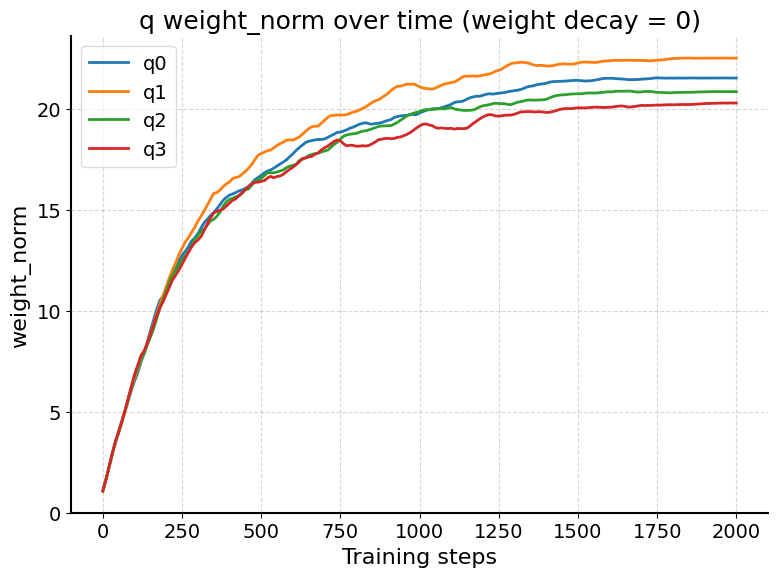

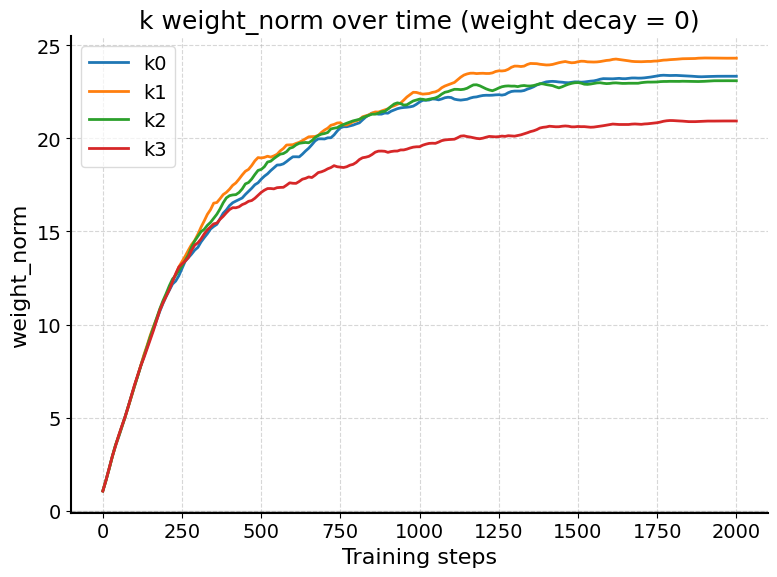

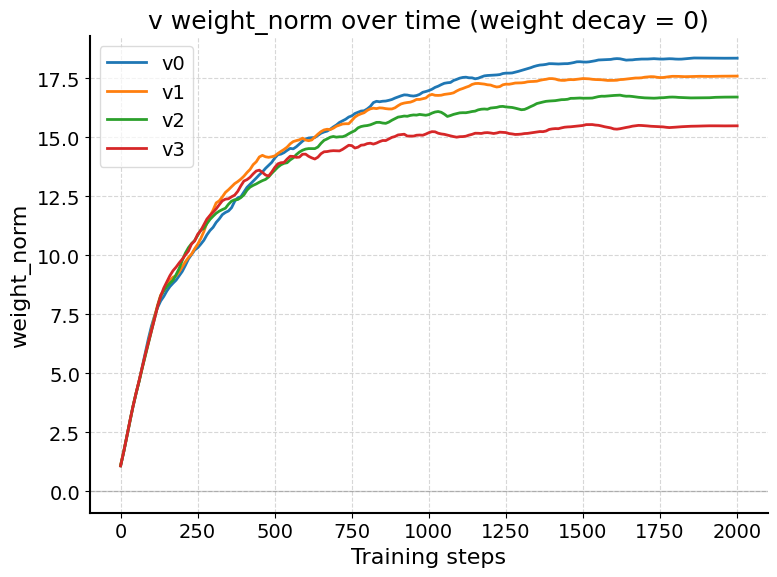

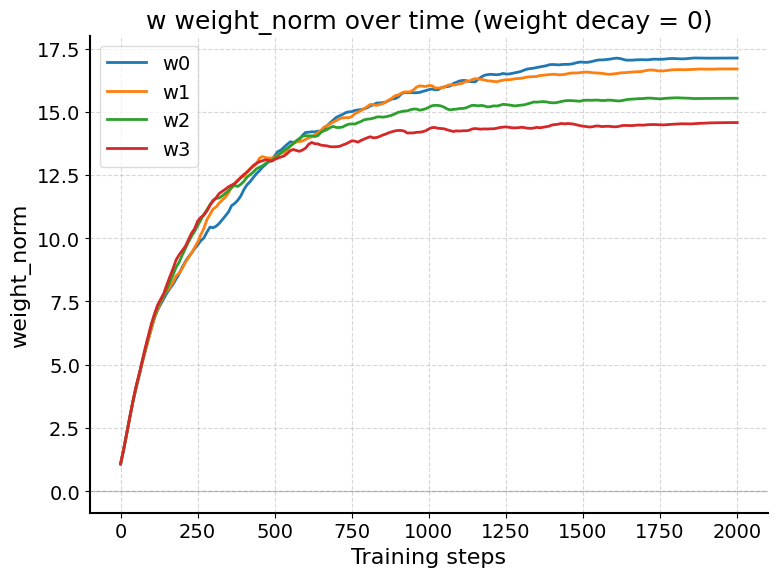

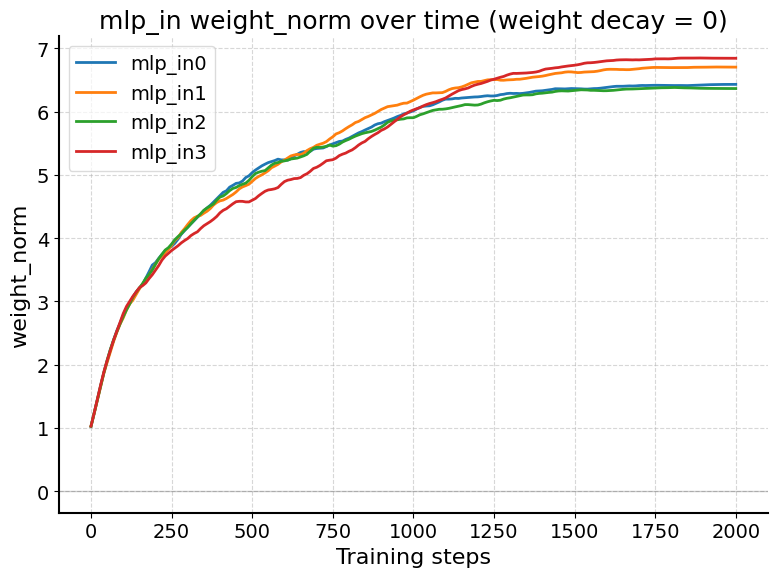

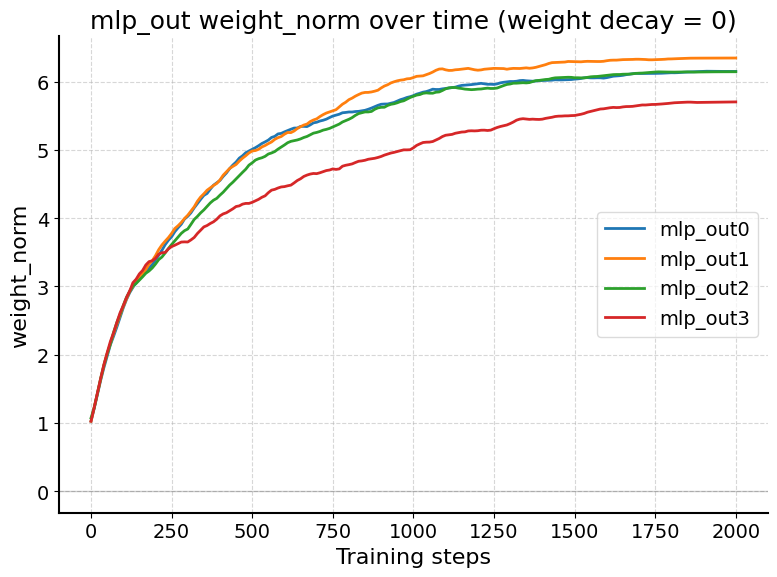

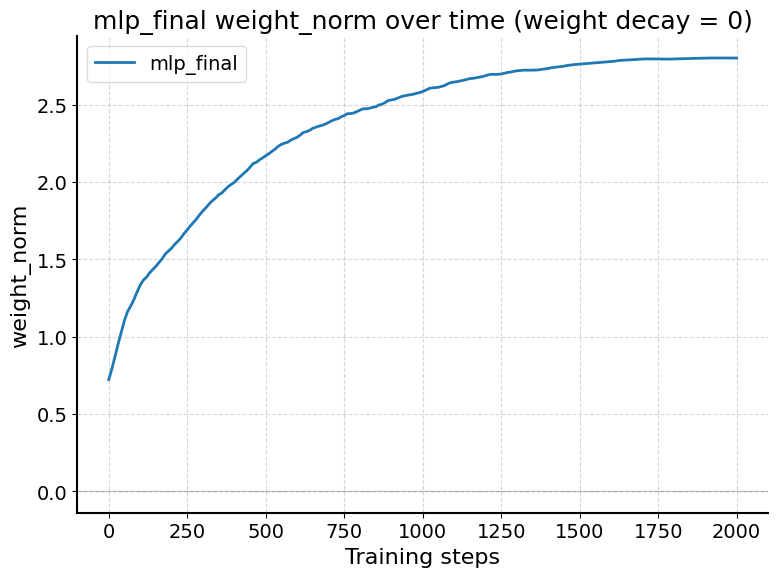

In [12]:
for t in ["q", "k", "v", "w", "mlp_in", "mlp_out", "mlp_final"]:
    plot_observable(t, "weight_norm")